### Predict future loan demand or interest rates using time series analysis.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from scipy import stats
import warnings

In [20]:
# Functions:

# Function to create multiple train-test splits
def create_multiple_ts_splits(data, n_splits=3, test_size=0.2):
    splits = []
    for i in range(n_splits):
        split_point = int(len(data) * (1 - test_size * (i + 1)))
        train = data.iloc[:split_point]
        test = data.iloc[split_point:int(len(data) * (1 - test_size * i))]
        splits.append((train, test))
    return splits

# Function to evaluate forecasts
def evaluate_forecasts(actual, forecasts):
    mse = mean_squared_error(actual, forecasts)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, forecasts)
    return mse, rmse, mae

# Define a function to fit and evaluate models
def fit_arima_model(train_data, test_data, order, model_name):
    # Fit the ARIMA model
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    
    # Forecast for the test period
    forecast = model_fit.forecast(steps=len(test_data))
    
    # Calculate performance metrics
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, forecast)
    
    # Print the model's performance
    print(f"\nModel: {model_name}")
    print(f"AIC: {model_fit.aic}")
    print(f"BIC: {model_fit.bic}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    
    # Return the performance metrics and model information
    return {
        'Model': model_name,
        'AIC': model_fit.aic,
        'BIC': model_fit.bic,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }


In [21]:
# Disable warnings
warnings.filterwarnings('ignore')

In [22]:
data = pd.read_csv('data.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Display first few rows of the filtered data
print(data.head())

        Date  Interest Rate
0 2000-01-03           6.58
1 2000-01-04           6.49
2 2000-01-05           6.62
3 2000-01-06           6.57
4 2000-01-07           6.52


### Train and test data split

Full dataset shape: (5002, 1)
Train set shape: (4001, 1)
Test set shape: (1001, 1)
Number of multiple splits: 3


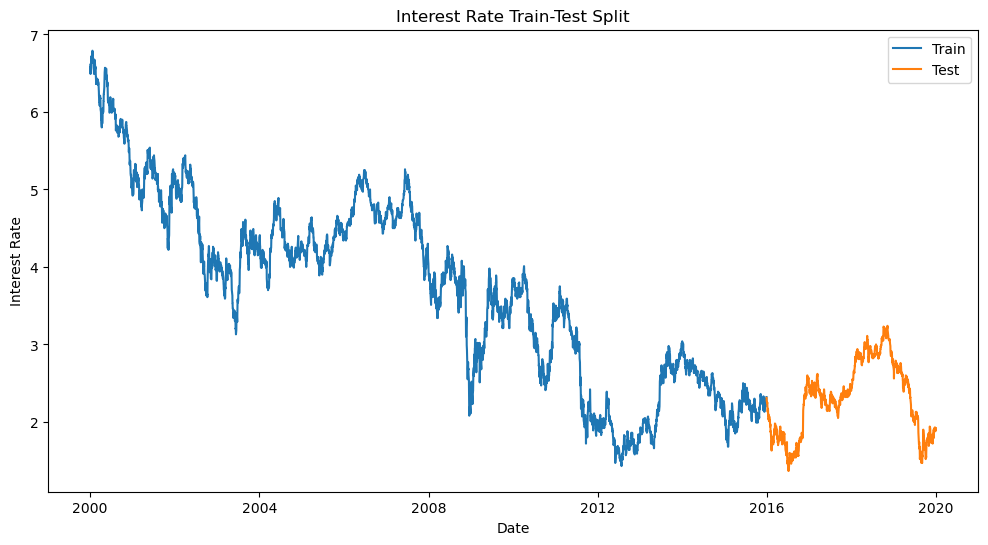

In [23]:
# Sort the dataframe by date to ensure chronological order
data = data.sort_values('Date')

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Define the split point (e.g., use the last 20% of the data for testing)
split_point = int(len(data) * 0.8)

# Split the data
train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]

# Create multiple splits
multiple_splits = create_multiple_ts_splits(data)

# Print some information about the splits
print(f"Full dataset shape: {data.shape}")
print(f"Train set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")
print(f"Number of multiple splits: {len(multiple_splits)}")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Train')
plt.plot(test_data.index, test_data['Interest Rate'], label='Test')
plt.title('Interest Rate Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

### Fiding best Arima model parameters

There are several methods to determine ARIMA (Autoregressive Integrated Moving Average) parameters. Here's an overview of some common approaches:

#### Auto ARIMA aproach

In [26]:
auto_model = auto_arima(train_data, start_p=0, start_q=0, max_p=5, max_q=5, d=None, 
                        test_data='adf', trace=True, error_action='ignore', 
                        suppress_warnings=True, stepwise=True)

print(f"Best ARIMA order (auto ARIMA aproach): {auto_model.order}")

# Fit the best ARIMA model
best_arima = ARIMA(train_data, order=auto_model.order)
arima_result = best_arima.fit()

# Get residuals
residuals = arima_result.resid

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11041.462, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11039.533, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11039.541, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11042.236, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11037.485, Time=0.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.104 seconds
Best ARIMA order (auto ARIMA aproach): (0, 1, 0)


This method uses the auto_arima function from the pmdarima library, which automatically searches for the best ARIMA order by iteratively fitting different models and comparing their AIC values. The best model found by this approach is ARIMA(0,1,0) with an AIC of -21060.687.

#### Manual approach

In [31]:
# List of ARIMA models to fit
arima_orders = [
    ((1, 1, 1), "ARIMA(1,1,1)"),
    ((1, 1, 0), "ARIMA(1,1,0)"),
    ((0, 1, 1), "ARIMA(0,1,1)"),
    ((0, 1, 0), "ARIMA(0,1,1)"),
    ((1, 0, 1), "ARIMA(1,0,1)")
]

# Fit each ARIMA model and compare their performance
results = []  # Ensure this is initialized properly outside the loop

for order, model_name in arima_orders:
    result = fit_arima_model(train_data, test_data, order, model_name)  # Pass the univariate series
    results.append(result)  # Make sure to append the result correctly

# Convert results into a DataFrame for easier comparison
results_df = pd.DataFrame(results)

# Print all results
print("\nComparison of ARIMA Models:")
print(results_df)

# Optional: Sort by AIC or any other metric to find the best model
results_df_sorted = results_df.sort_values(by='AIC')
print("\nBest ARIMA order (manual aproach):")
print(results_df_sorted.head(1))


Model: ARIMA(1,1,1)
AIC: -11038.272784226781
BIC: -11019.390635306476
MSE: 0.22236809251006248
RMSE: 0.47155921421393354
MAE: 0.39539728754268616

Model: ARIMA(1,1,0)
AIC: -11040.29726126111
BIC: -11027.709161980905
MSE: 0.22235132001400662
RMSE: 0.47154142979594765
MAE: 0.39542109969461936

Model: ARIMA(0,1,1)
AIC: -11040.304461628282
BIC: -11027.716362348077
MSE: 0.22235013097208567
RMSE: 0.47154016899102635
MAE: 0.39542314322753686

Model: ARIMA(0,1,1)
AIC: -11042.236056463295
BIC: -11035.942006823192
MSE: 0.22236103896103895
RMSE: 0.47155173519035953
MAE: 0.39540459540459544

Model: ARIMA(1,0,1)
AIC: -11031.466372618212
BIC: -11006.289174182783
MSE: 0.7823200156948509
RMSE: 0.8844885616529198
MAE: 0.7676132644798822

Comparison of ARIMA Models:
          Model           AIC           BIC       MSE      RMSE       MAE
0  ARIMA(1,1,1) -11038.272784 -11019.390635  0.222368  0.471559  0.395397
1  ARIMA(1,1,0) -11040.297261 -11027.709162  0.222351  0.471541  0.395421
2  ARIMA(0,1,1) -1

This method tests a predefined set of ARIMA orders and compares their performance using AIC, BIC, MSE, RMSE, and MAE metrics. According to your results, the best model by AIC is ARIMA(0,1,1) with an AIC of -21060.686908.

### Grid Search 
This involves testing multiple combinations of p, d, and q within a specified range (see file grid_search).

#### Summary
In practice, a combination of these methods often yields the best results. Start with auto ARIMA for a quick baseline, then refine using manual selection or grid search, and validate using cross-validation.

### ARIMA (0,1,0)

In [41]:
order = (0, 1, 0)  
model = ARIMA(train_data['Interest Rate'], order=order)
results = model.fit()

# Print model summary
print(results.summary())

# Forecast
forecast = results.forecast(steps=len(test_data))

# Evaluate forecasts
mse, rmse, mae = evaluate_forecasts(test_data['Interest Rate'], forecast)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

                               SARIMAX Results                                
Dep. Variable:          Interest Rate   No. Observations:                 4001
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5522.118
Date:                Fri, 11 Oct 2024   AIC                         -11042.236
Time:                        17:47:44   BIC                         -11035.942
Sample:                             0   HQIC                        -11040.005
                               - 4001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0037   5.58e-05     66.348      0.000       0.004       0.004
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               962.39
Prob(Q):                              0.79   Pr

- AIC: -11042.236, which indicates this is the best model compared to the other ARIMA models tested. 

- BIC:  -11035.942 

- MSE: 0.22236 (Mean Squared Error of the model's predictions on the test set) 

- RMSE: 0.47155 (Root Mean Squared Error) 

- MAE: 0.39540 (Mean Absolute Error) 

- Model Diagnostics:
Ljung-Box test (Q-statistic) p-value is 0.79, indicating no significant autocorrelation in the residuals.
Jarque-Bera test p-value is 0.00, suggesting the residuals are not normally distributed.
Heteroskedasticity test p-value is 0.00, indicating the presence of heteroskedasticity in the residuals.
Skewness is close to 0 (0.01), but kurtosis is high (5.40), confirming non-normal distribution of residuals.

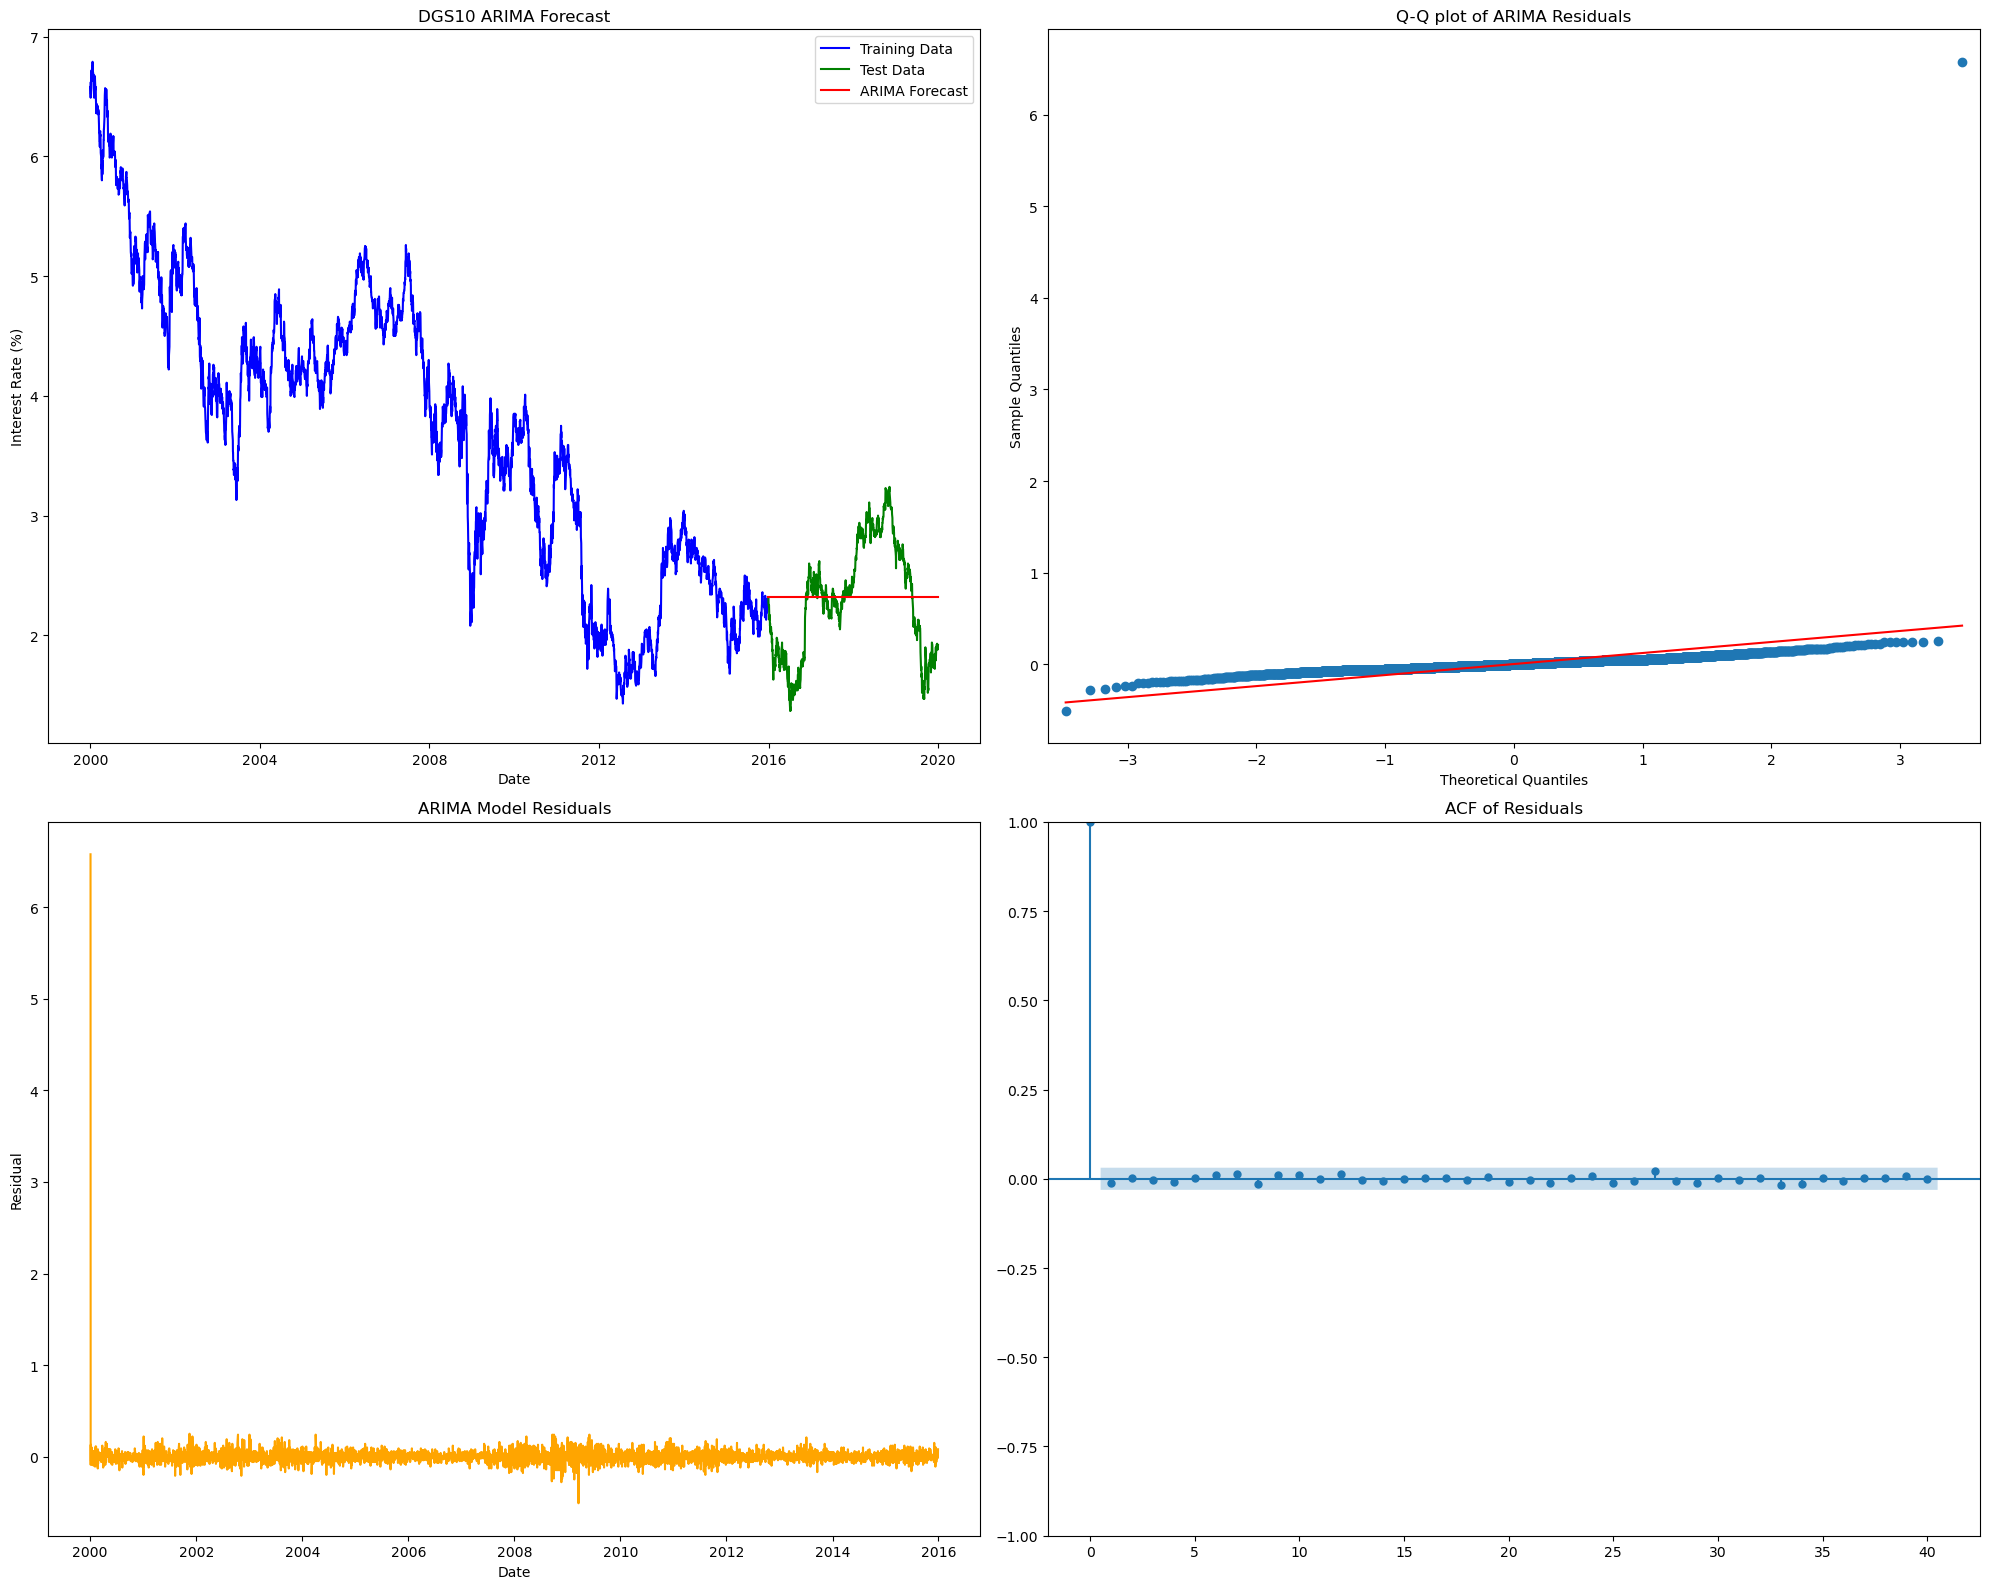

In [49]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# DGS10 ARIMA Forecast
ax1.plot(train_data.index, train_data['Interest Rate'], label='Training Data', color='Blue')
ax1.plot(test_data.index, test_data['Interest Rate'], label='Test Data', color='green')
ax1.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
ax1.set_title('DGS10 ARIMA Forecast')
ax1.set_xlabel('Date')
ax1.set_ylabel('Interest Rate (%)')
ax1.legend()

# Q-Q plot of ARIMA Residuals
residuals = results.resid
sm.qqplot(residuals, line='s', ax=ax2)
ax2.set_title('Q-Q plot of ARIMA Residuals')

# ARIMA Model Residuals
ax3.plot(train_data.index, residuals, color='orange')
ax3.set_title('ARIMA Model Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual')

# ACF of Residuals
plot_acf(residuals, lags=40, ax=ax4)
ax4.set_title('ACF of Residuals')

plt.tight_layout()
plt.show()

The model seems to provide reasonable accuracy for the dataset based on obtained error metrics. However, the forecast plot shows that the ARIMA(0,1,0) forecast is relatively flat, failing to capture the significant downward trend in the test data (2019 onwards). This could indicate that the model is not fully capturing all the nuances of the time series, especially the trend or volatility. The Q-Q plot for the residuals of ARIMA model shows a significant outlier, as indicated by the single point far from the red line. This outlier could potentially distort the model's performance and residual diagnostics, and addressing it could improve the model’s fit. To address the outlier we can:

1. Examine and Validate the Outlier:
- Check for Data Errors: Ensure the outlier is not a result of a data entry mistake or a data processing issue. Sometimes, such outliers could be incorrect values due to errors in data collection.
- Understand the Event: If the outlier represents a significant real-world event (e.g., a sudden policy change, economic shock, or crisis), it might not be appropriate to remove it. You might instead want to model such events separately or flag them in the model.

2. Remove or Transform the Outlier:
- Remove the Outlier: If the outlier appears to be spurious (e.g., an error), you could remove it from the dataset to prevent it from skewing the model.
- Cap the Outlier (Winsorizing): You can cap extreme values to a certain percentile (e.g., 99th percentile) to reduce their impact while keeping the data intact.
3. Use Robust Methods:
- Robust ARIMA or Robust Regression: Use robust modeling techniques that are less sensitive to outliers. Robust regression methods place less emphasis on extreme values, reducing their impact on the model.

4. Treat Outliers as Exogenous Shocks:
- Include External Regressors (X): If the outlier is related to an external event (like a sudden market shock), you could treat it as an exogenous factor. Use ARIMAX (ARIMA with exogenous variables) to account for such shocks explicitly in the model.
5. Log Transformation:
- Log Transform the data to reduce the impact of large values. This is particularly useful if the outlier is much larger than the rest of the data, as it compresses large values and reduces skewness in the data.
6. Investigate ARCH/GARCH Models:
- If the outlier represents volatility clustering or heteroskedasticity, an ARCH or GARCH model may be more appropriate for capturing the dynamics of the variance over time. These models are useful when volatility is not constant, as might be the case for financial data like interest rates.

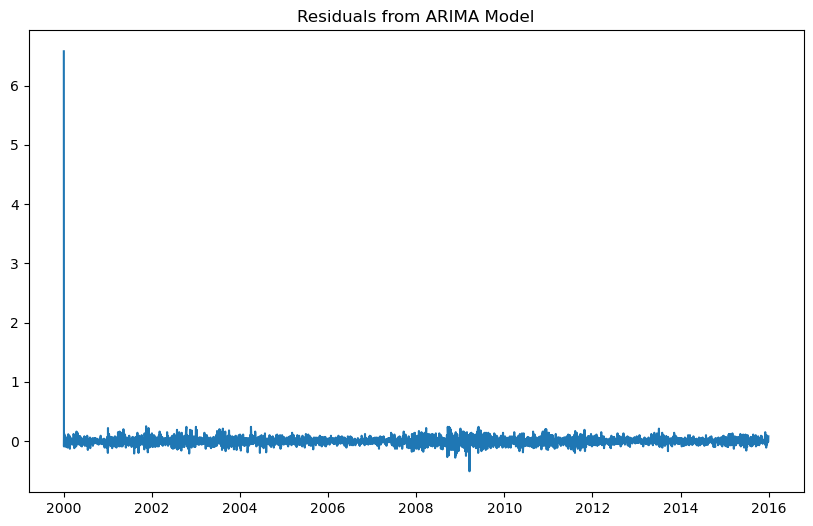

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.799583673350842e+18
Iteration:      2,   Func. Count:     20,   Neg. LLF: -5613.400457298867
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5613.4004784686185
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5613.40
Distribution:                  Normal   AIC:                          -11218.8
Method:            Maximum Likelihood   BIC:                          -11193.6
                                        No. Observations:                 4001
Date:                Fri, Oct 11 2024   Df Residuals:                     4000
Time:     

In [53]:
from arch import arch_model

# Step 1: Fit ARIMA(0, 1, 0) to model the mean
model = ARIMA(train_data, order=(0, 1, 0))
arima_result = model.fit()

# Step 2: Obtain the residuals from the ARIMA model
residuals = arima_result.resid

# Step 3: Plot residuals to visualize volatility clustering
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title("Residuals from ARIMA Model")
plt.show()

# Step 4: Fit GARCH(1,1) model on the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_result = garch_model.fit()

# Step 5: Print the GARCH model summary
print(garch_result.summary())

# Step 6: Forecast future volatility using the GARCH model
garch_forecast = garch_result.forecast(horizon=10)  # Forecast volatility for the next 10 steps
print("\nForecasted Variance:")
print(garch_forecast.variance[-1:])


### GARCH(1, 1) model 

#### Residuals Plot:

The plot shows a large spike at the beginning of the series (around 2000), which could indicate a significant shock or outlier in the data.
After this initial spike, the residuals appear to fluctuate around zero, which is generally a good sign.
There's visible volatility clustering, where periods of high volatility are followed by periods of high volatility, and low volatility periods are followed by low volatility.
The volatility seems to decrease over time, with larger fluctuations in the earlier years and smaller fluctuations in more recent years.


#### GARCH Model Results:

The GARCH(1,1) model converged successfully, which is positive. The mean model shows a slightly negative constant (-0.0016717), which is statistically significant at the 5% level (p-value = 0.0403).

1. In the volatility model:
- The omega (constant) term is 0.00029044 and is significant (p-value = 0.00196).
- The alpha[1] coefficient (0.2000) represents the impact of past shocks on current volatility and is significant.
- The beta[1] coefficient (0.7800) represents the persistence of volatility and is highly significant.
- The sum of alpha[1] and beta[1] is 0.98, which indicates high persistence in volatility.


2. Model Fit:
- The AIC (-11218.8) and BIC (-11193.6) values are quite low, suggesting a good fit.
- The log-likelihood is positive (5613.40), which is also a good sign.


3. Volatility Forecast:

- The forecasted variance shows an increasing trend over the next 10 periods, starting from 0.003663 and rising to 0.005468.
- This suggests that the model expects volatility to increase in the near future.






Forecasted variance length: 1001
Forecasted variance: [0.00366315 0.00388045 0.0040934  ... 0.01452733 0.01452733 0.01452733]


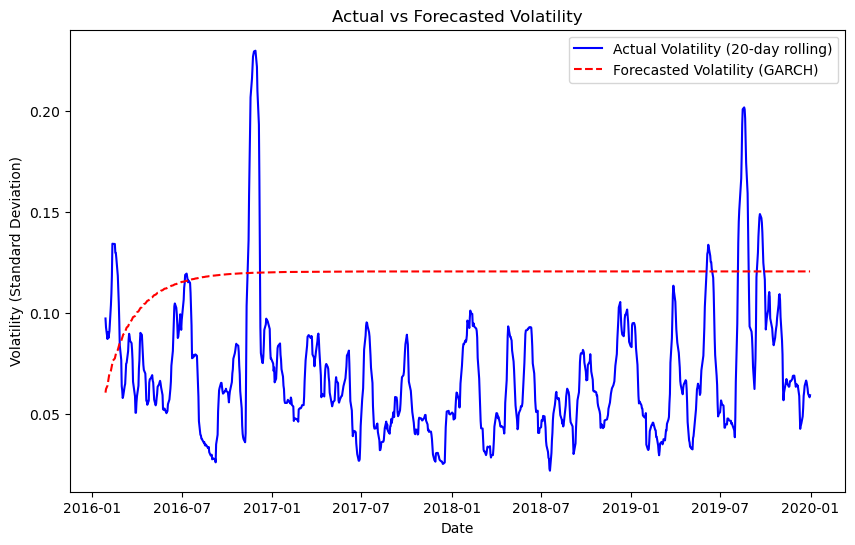

Mean Squared Error (MSE): 0.0035806307750950316
Mean Absolute Error (MAE): 0.05498731197651337


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Forecast volatility for the test period using the GARCH model
# Correct the start and horizon for the forecast method
horizon = len(test_data)  # Forecast horizon based on the length of the test data
garch_forecast = garch_result.forecast(start=len(train_data) - 1, horizon=horizon)

# Step 2: Correctly extract forecasted variance (make sure the slice is correct)
forecasted_variance = garch_forecast.variance.iloc[-horizon:].values.flatten()  # Extract the variance for the test period

# Debugging: Print the forecasted variance
print(f"Forecasted variance length: {len(forecasted_variance)}")
print(f"Forecasted variance: {forecasted_variance}")

# Calculate forecasted volatility (standard deviation)
forecasted_volatility = np.sqrt(forecasted_variance)

# Step 3: Calculate actual volatility in the test set (using a 20-day rolling window)
rolling_window = 20  # Adjust this value based on your data's frequency
actual_volatility = test_data['Interest Rate'].rolling(window=rolling_window).std().dropna()

# Ensure that the lengths of actual and forecasted volatility match
min_length = min(len(actual_volatility), len(forecasted_volatility))
actual_volatility = actual_volatility[:min_length]
forecasted_volatility = forecasted_volatility[:min_length]

# Step 4: Plot actual vs forecasted volatility
plt.figure(figsize=(10, 6))
plt.plot(test_data.index[rolling_window-1:rolling_window-1+min_length], actual_volatility, label='Actual Volatility (20-day rolling)', color='blue')
plt.plot(test_data.index[rolling_window-1:rolling_window-1+min_length], forecasted_volatility, label='Forecasted Volatility (GARCH)', color='red', linestyle='dashed')
plt.title('Actual vs Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()
plt.show()

# Step 5: Calculate and print error metrics
mse = mean_squared_error(actual_volatility, forecasted_volatility)
mae = mean_absolute_error(actual_volatility, forecasted_volatility)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


In [253]:
from arch import arch_model
import numpy as np

# Try different GARCH orders
garch_orders = [(1,1), (1,2), (2,1), (2,2)]
best_aic = np.inf
best_model = None
best_p, best_q = 0, 0

for p, q in garch_orders:
    model = arch_model(residuals, vol='Garch', p=p, q=q, dist='t')
    result = model.fit(disp='off')
    if result.aic < best_aic:
        best_aic = result.aic
        best_model = result
        best_p, best_q = p, q

print(f"Best GARCH order: GARCH({best_p},{best_q})")

Best GARCH order: GARCH(2,2)


c:\Users\baubl\.conda\envs\dgs10\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [60]:
# Fetch additional economic indicators
cpi = fred.get_series('CPIAUCSL')  # Consumer Price Index
gdp = fred.get_series('GDP')  # Gross Domestic Product
unemployment = fred.get_series('UNRATE')  # Unemployment Rate
